## 1. Lectura de la imagen

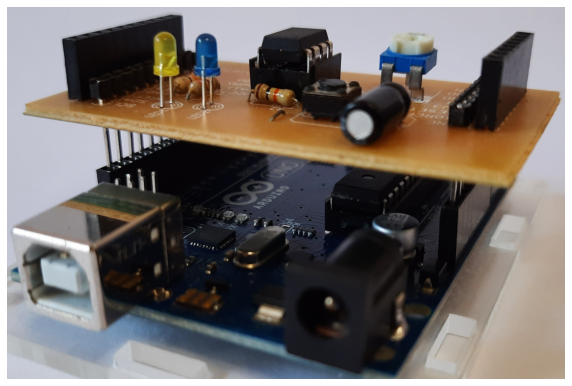

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Ubicación y nombre de la imagen
path = 'docs/'
file_name = 'ardu_shield.jpg'

# Objeto Image de la imagen en 'path + file_name'
# Se recorta la zona de interés (left=850, upper=100, right=3700, lower=2000)
im_object = Image.open(path + file_name).crop((850,100, 3700, 2000))

plt.figure(figsize=(10,10))
plt.imshow(im_object)
plt.axis('off')
plt.show()

## 2. Normalización

In [2]:
# Convertir en una matriz Numpy de uint8
im = np.array(im_object).astype(np.uint8)

# Se normaliza la imagen
im_norm = im/255.0

print(im_norm[0])

[[0.74509804 0.76078431 0.80392157]
 [0.74117647 0.75686275 0.8       ]
 [0.7372549  0.75294118 0.79607843]
 ...
 [0.7372549  0.73333333 0.76470588]
 [0.74117647 0.7372549  0.76862745]
 [0.74117647 0.7372549  0.76862745]]


In [3]:
im.shape

(1900, 2850, 3)

## 3. Conversión de espacios

* Se definen funciones encargadas de realizar la conversión de los espacion YIQ y RGB, según las matrices correspondientes.

* Primero se crea una función que permita realiza el producto entre dos matrices de las características en mención.

In [4]:
def apply_matrix(image, matrix):
    """
    Entradas:
        image  -> Array de 3-dimensiones de una imagen RGB 
                  con la forma: (alto, ancho, canales).
                  
        matrix -> Matríz de 3x3 con los valores a operar en 
                  la imagen.
    
    Salida:
        Producto matricial de 'image' y 'matrix' con las 
        dimensiones de 'image'.
    """
    return np.matmul(image.reshape((-1,3)), matrix.T).reshape(image.shape)

### 3.1. $RGB\rightarrow YIQ$

In [5]:
# Conversión RGB -> YIQ
def rgb2yiq(image):
    """
    Entrada: 
        image -> Array de 3-dimensiones de una imagen RGB 
                 con la forma: (alto, ancho, canales).
                 
                 image[..., 0] -> R
                 image[..., 1] -> G
                 image[..., 2] -> B
    
    Salida:
        yiq_image -> Array de 3-dimensiones de la imagen 
                     'image' en el espacio YIQ. 
        
                     yiq_image[..., 0] -> Y
                     yiq_image[..., 1] -> I
                     yiq_image[..., 2] -> Q
    """
    
    rgb2yiq_matrix = np.array([[0.299,       0.587,       0.114],
                               [0.59590059, -0.27455667, -0.32134392],
                               [0.21153661, -0.52273617,  0.31119955]])
    
    if image.max() > 1:
        image = image/255.0
        print("-> Reescalando la imagen en un rango de 0 a 1")
    
    yiq_image = apply_matrix(image, rgb2yiq_matrix)
    
    return yiq_image

### 3.2. $YIQ\rightarrow RGB$

In [6]:
# Conversión YIQ -> RGB
def yiq2rgb(image):
    """
    Entrada: 
        image -> Array de 3-dimensiones de una imagen en el 
                 espacio YIQ con la forma: (alto, ancho, canales).
                 
                 image[..., 0] -> Y
                 image[..., 1] -> I
                 image[..., 2] -> Q
    
    Salida:
        rgb_image -> Array de 3-dimensiones de la imagen 
                     'image' en el espacio RGB. 
        
                     rgb_image[..., 0] -> R
                     rgb_image[..., 1] -> G
                     rgb_image[..., 2] -> B
    """
    
    yiq2rgb_matrix = np.array([[1,  0.9663,  0.6210],
                               [1, -0.2721, -0.6474],
                               [1, -1.1070,  1.7046]])
    
    rgb_image = np.clip(apply_matrix(image, yiq2rgb_matrix), 0, 1)
    
    return rgb_image

## 4. Cambio de luminancia (Y) y saturación (IQ)

* Se declaran dos funciones: ***change_yiq*** y ***plot_1x3***, las cuales se encargan de modificar los valores de YIQ según los coeficientes ingresados por el usuario y graficarlos en un grid de 1 fila con 3 columnas.

In [7]:
def change_yiq(yiq_image, alphas=[], betas=[], plot=True):
    """
    Entradas:
        yiq_image -> Array en 3-dimensiones de la imagen en el espacio YIQ
        alphas    -> Lista con los coeficientes de la luminancia
        betas     -> Lista con los coeficientes de la saturacion
        plot      -> Indica si se grafican los resultados

    Salida:
        Retorna un diccionario cuyos 'keys' son el nombre de la
        nueva imagen y los 'values' son un array de 3-dimensiones
        de la nueva imagen en el espacio RGB en bytes. Ejemplo:

        {
          'image0': new_rgb_image0,
          'image1': new_rgb_image1,
          ...
        }
    """
    # Nuevos valores de YIQ
    new_images = {}
    
    # Debe haber misma cantidad de alphas que betas
    if len(alphas) != len(betas):
        print('La cantidad de coeficientes de Alpha y Beta deben ser iguales')
        print('Número de Alphas: ' + str(len(alphas)))
        print('Número de Betas: ' + str(len(betas)))
        
        return new_images
    
    for i in range(0, len(alphas)):
        
        yiq_new_image = yiq_image.copy()
        
        # Cambio del canal 0 -> 'Y' (luminancia)
        yiq_new_image[..., 0] = yiq_new_image[..., 0] * alphas[i]
        #yiq_new_image[..., 0] = np.clip(yiq_new_image[..., 0], None, 1)
        
        # Cambio de los canales 1 y 2 -> 'Q' e 'I' (saturación)
        yiq_new_image[..., 1] = yiq_new_image[..., 1] * betas[i]
        yiq_new_image[..., 2] = yiq_new_image[..., 2] * betas[i]
        #yiq_new_image[..., 1] = np.clip(yiq_new_image[..., 1], -0.5957, 0.5957)
        #yiq_new_image[..., 2] = np.clip(yiq_new_image[..., 2], -0.5226, 0.5226)
        
        rgb_new_image = (yiq2rgb(yiq_new_image)*255).astype('uint8')
        
        new_images['image' + str(i)] = rgb_new_image
    
    if plot:
        plot_1x3(new_images, alphas, betas)
        
    return new_images

In [8]:
def plot_1x3(images, alphas=[], betas=[]):
    """
    Entradas:
        images - diccionario cuyos 'keys' son el nombre de la
                 imagen a graficar y los 'values' son un array
                 de 3-dimensiones con los valores de la imagen.

        alphas - Lista con los coeficientes de la luminancia
        betas  - Lista con los coeficientes de la saturacion

    Acción:
        Grafica las imagenes contenidas en 'images' en un subplot 
        de 1 fila y 3 columnas.
    """
    fig, axs = plt.subplots(1, 3, figsize=(15,15))

    for image_name, rgb_image in images.items():

        # Toma el numero de la imagen, es decir, si el nombre 
        # es 'image4' entonces -> index=4
        index = int(image_name[5::])
        
        axs[index].set_title("$\\alpha=${}     $\\beta=${}".format(alphas[index], betas[index]))
        axs[index].imshow(rgb_image)
        axs[index].set_axis_off()

    plt.show()

### $\alpha < 1$, $\beta = 1$

-> Reescalando la imagen en un rango de 0 a 1


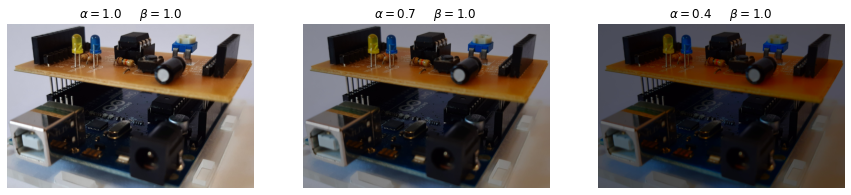

In [9]:
alphas = [1.0, 0.7, 0.4]
betas  = [1.0, 1.0, 1.0]

new_RGB_images = change_yiq(rgb2yiq(im), alphas, betas)

### $\alpha > 1$, $\beta = 1$

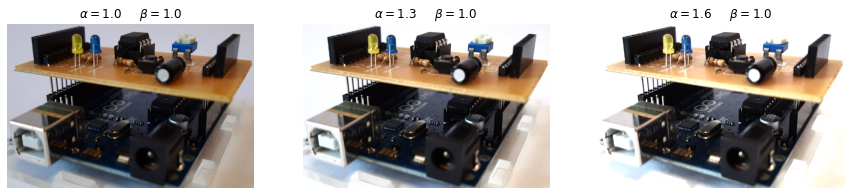

In [10]:
alphas = [1.0, 1.3, 1.6]
betas  = [1.0, 1.0, 1.0]

new_RGB_images = change_yiq(rgb2yiq(im_norm), alphas, betas)

### $\alpha = 1$, $\beta < 1$

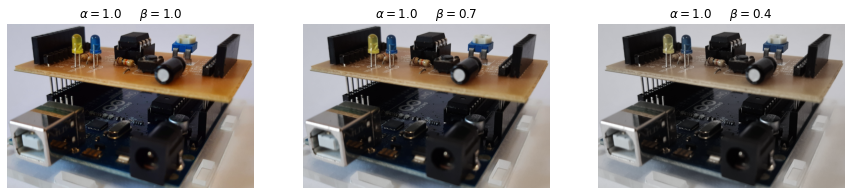

In [11]:
alphas = [1.0, 1.0, 1.0]
betas  = [1.0, 0.7, 0.4]

new_RGB_images = change_yiq(rgb2yiq(im_norm), alphas, betas)

### $\alpha = 1$, $\beta > 1$

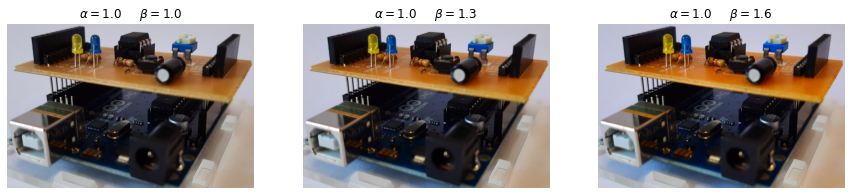

In [12]:
alphas = [1.0, 1.0, 1.0]
betas  = [1.0, 1.3, 1.6]

new_RGB_images = change_yiq(rgb2yiq(im_norm), alphas, betas)

### Combinación de $\alpha$ y $\beta$

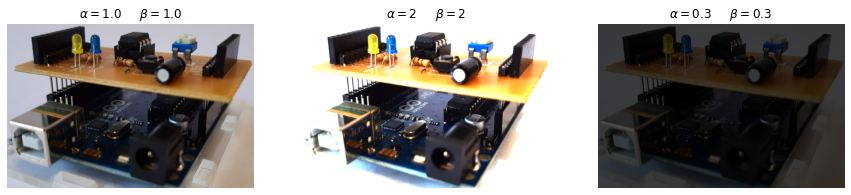

In [13]:
alphas = [1.0, 2, 0.3]
betas  = [1.0, 2, 0.3]

new_RGB_images = change_yiq(rgb2yiq(im_norm), alphas, betas)

## 5. Mapas cromáticos

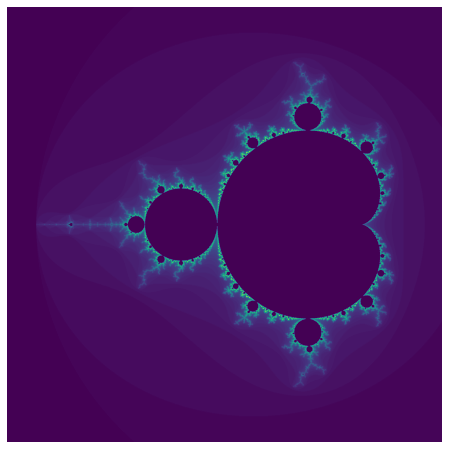

In [14]:
mandelbrot = np.load(path + 'mandelbrot.npy')

plt.figure(figsize=(8,8))
plt.imshow(mandelbrot)
plt.axis('off')
plt.show()

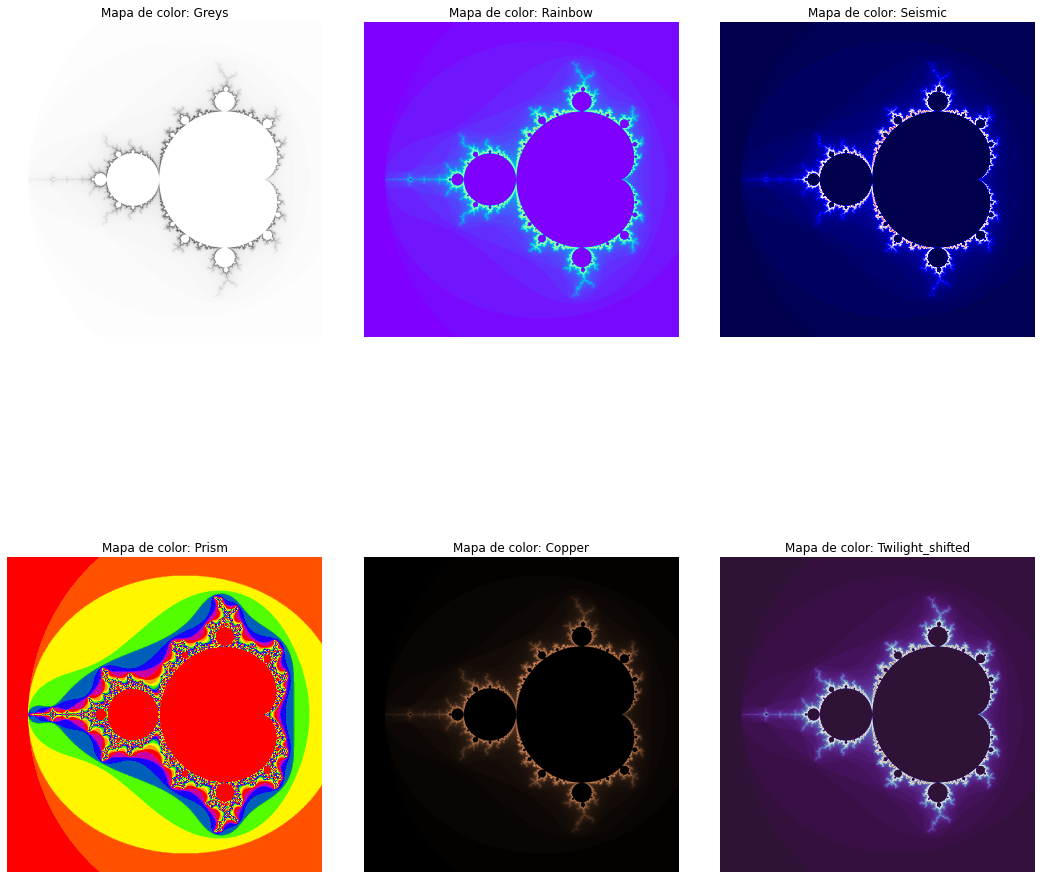

In [15]:
palettes = ['Greys', 'rainbow', 'seismic', 'prism', 'copper', 'twilight_shifted']

fig, axs = plt.subplots(2, 3, figsize=(15,15))
fig.tight_layout()

row = 0
col = 0

for palette in palettes:

    axs[row, col].set_title('Mapa de color: ' + palette.capitalize())
    axs[row, col].imshow(mandelbrot, cmap=palette)
    axs[row, col].set_axis_off()
    
    col += 1
    if col > 2:
        col = 0
        row += 1

plt.show()

## Links de interés

* [Colormaps in Matplotlib](https://matplotlib.org/stable/tutorials/colors/colormaps.html)

* [Snapshots image gallery](https://www.climate.gov/maps-data/data-snapshots/data-source/temperature-minimum-1981-2010-monthly-average)